# Predictive Maintenance of Turbofan Jet Engine: Baseline Model

For the baseline of the model training, we will be using the most basic model without any preprocessing so that we can see how significant the improvement is after applying adequate data preprocessing and features engineering.
- Baseline model: Linear Regression

# Regression - RUL Prediction

## 1. Load Dataset

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import read_dataset

In [2]:
train, test, test_rul = read_dataset("FD001")
train.shape, test.shape, test_rul.shape

((20631, 26), (13096, 26), (100,))

In [3]:
train.head()

,unit,time_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## 2. Establish Evaluation Metrics

Since we are solving a regression problem, we have choose two evaluation metrics to evaluate the trained models for estimating RUL.
1. **RMSE** - Root Mean Squared Error - one of the standard metrics for regression, it's a squared root of averaged squared difference between actual and predicted values. An important characteristic of RMSE is that it penalizes larger errors more. 

$$ RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}{(y_i - \hat{y_i})^2}} $$

2. **MAE** - Mean Absolute Error - an average of absolute difference between actual and predicted values. MAE uses the same scale as the data and it's more robust to outliers.

$$ MAE = \frac{1}{n} \sum_{i=1}^{n}{ |y_i - \hat{y_i}| } $$

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rul_evaluation_score(model, X, true_rul, metrics='all'):
    '''
    Calculate evaluation metrics:
        1. rmse - Root Mean Squared Error
        2. mae - Mean Absolute Error
        
    Returns
    -------
    dict with metrics
    '''
    scores_f = {
        'rmse': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error
    }

    pred_rul = model.predict(X)

    def calculate_scores(metrics_list):
        return {m: scores_f[m](true_rul, pred_rul) for m in metrics_list}

    if metrics == 'all':
        return calculate_scores(scores_f.keys())
    elif isinstance(metrics, list):
        return calculate_scores(metrics)

## 3. Establish Evaluation Methodology

The most important aspect to discuss in the cross-validation is that the the same engine cannot appear in 2 different folds. In time-series data or data where observations are grouped, standard k-fold cross-validation can lead to **data leakage**. This happens because the same engine can appear in both training and validation sets, which violates the assumption that the training and validation sets should be independent.

To avoid this, **GroupKFold** cross-validation method will be used, which ensures that the same group (engine unit) does not appear in both training and validation sets.

In [5]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_validate

In [6]:
class CustomGroupKFold(GroupKFold):
    '''
    CV Splitter which drops validation records with 
    RUL values outside of test set RULs ranges
    '''
    def split(self, X, y, groups):
        splits = super().split(X, y, groups)

        for train_ind, val_ind in splits:
            yield train_ind, val_ind[(y[val_ind] > 6) & (y[val_ind] < 135)]

In [7]:
def evaluate(model, X, y, groups, cv, 
             scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'], 
             n_jobs=None, 
             verbose=False):
    '''
    Evaluate a model with Cross-Validation
    '''
    cv_results = cross_validate(
        model, 
        X=X,
        y=y,
        groups=groups,
        scoring=scoring,
        cv=cv,
        return_train_score=True,
        return_estimator=True,
        n_jobs=n_jobs,
        verbose=verbose
    )
    
    for k, v in cv_results.items():
        if k.startswith('train_') or k.startswith('test_'):
            k_sp = k.split('_')
            print(f'[{k_sp[0]}] :: {" ".join(k_sp[2:])} : {np.abs(v.mean()):.2f} +- {v.std():.2f}')
    return cv_results

## 4. Build Baseline Model and Cross-Validate

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_selector

from utils import calculate_RUL

In [9]:
get_ftr_names = make_column_selector(pattern='sensor')

In [10]:
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

cv_result = evaluate(
    baseline_model,
    X=train[get_ftr_names(train)].values,
    y=calculate_RUL(train, upper_threshold=135),
    groups=train['unit'],
    cv=CustomGroupKFold(n_splits=5)
)

[test] :: root mean squared error : 23.42 +- 1.54
[train] :: root mean squared error : 23.80 +- 0.35
[test] :: mean absolute error : 19.32 +- 1.25
[train] :: mean absolute error : 19.42 +- 0.35


## 5. Evaluate Baseline Model on Test Set

In [11]:
# Train model on the whole dataset
baseline_model.fit(
    X=train[get_ftr_names(train)].values,
    y=calculate_RUL(train, upper_threshold=135)
)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [13]:
# Choose only the last cycle for each unit in the test set
X_test = test.groupby('unit').last().reset_index()

In [14]:
# Evaluate on the test set
rul_evaluation_score(baseline_model, X_test[get_ftr_names(test)], test_rul)

{'rmse': 22.368523506668193, 'mae': 17.88996899556987}

The results above will be used as our baseline when selecting the best ML models.

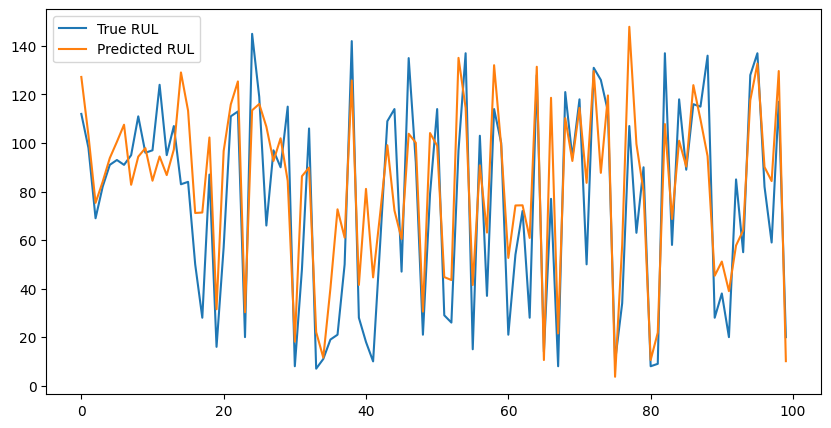

In [15]:
# plot the result
def plot_rul(y_true, y_pred):
    plt.figure(figsize=(12, 5))
    plt.plot(y_true, label='True RUL')
    plt.plot(y_pred, label='Predicted RUL')
    plt.legend()
    plt.show()

plot_rul(test_rul, baseline_model.predict(X_test[get_ftr_names(test)]))

The graph above will be compared to the selected model. We want to see whether the predicted RUL closely match with the true RUL or not.

In [16]:
# Print the predicted value vs true value

pd.DataFrame({
    'True RUL': test_rul,
    'Predicted RUL': baseline_model.predict(X_test[get_ftr_names(test)])
})

,True RUL,Predicted RUL
0,112.0,127.233806
1,98.0,103.124768
2,69.0,75.339804
3,82.0,84.046613
4,91.0,93.794439
...,...,...
95,137.0,132.722916
96,82.0,90.107619
97,59.0,84.319839
98,117.0,129.667877
